# Datasets

1. **Crop Recommendation Dataset:**
   [link](https://www.kaggle.com/datasets/varshitanalluri/crop-recommendation-dataset/data)
   - Map soil features (concentration of N, P, K, temperature, humidity, pH) to
     the most recommended crop to be planted for the soil.
   - Could be used reversedly to recommend the Nitogen fertilization based on
     the crop.
2. **Plant Health data:**
   [link](https://www.kaggle.com/datasets/ziya07/plant-health-data/data)
   - Contains moisu, ambient/soil temperature, humdity, light intensity, soil
     pH, N, P, K -> plant health status (stress, healthy, other) &
     electrochemical signals
   - **No specific plant species provided**
   - Could be used for IoT
3. **Leaf Color Chart:**
   [link](https://www.kaggle.com/datasets/rusiri/leaf-color-dataset-for-paddy/data)
   - Contains images of leafs with different nitrogen deficiency levels
   - Allow us to recommend if additional nitrogen is needed (**for rice crop
     only**)
   - How to properly use the LCC:
     [(Rice Knowledge Bank, n.d.)](http://www.knowledgebank.irri.org/step-by-step-production/growth/soil-fertility/leaf-color-chart)
   - Inferior alternatives
     - [Wheat Nitrogen deficiency & rust](https://www.kaggle.com/datasets/jocelyndumlao/wheat-nitrogen-deficiency-and-leaf-rust-image).
       This dataset classify both Nitrogen deficient and rust as "diseased."
     - [link](https://www.kaggle.com/datasets/myominhtet/nitrogen-deficiency-for-rice-crop/data).
       This dataset require background removed, perfect leave pictures.
4. **Tomato Village dataset:**
   [link](https://www.kaggle.com/datasets/mamtag/tomato-village)
   - Despite classify the tomato leaves into multiple diseases, it include a
     classification of "Nitrogen deficiency" and "healthy."
   - Provide object detection classification of the Nitrogen deficiency.
5. **Cucumber disease detection:**
   [link](https://www.kaggle.com/datasets/gauravduttakiit/cucumber-diseases-detection)
   - Classify pictures of cucumber leaves into **Healthy**, **N deficiency**,
     **NK deficiency,** and **K** deficiency
6. **Melon disease detection:**
   [link](https://www.kaggle.com/datasets/binnassor89/melon-macronutrient-deficiency-dataset)
   - Classify pictures of melon leaves into **Healthy**, **Ca deficiency**, **N
     deficiency,** and **K** deficiency
7. **Atmosphere data:** [link](https://browser.dataspace.copernicus.eu/)
   - My knowledge is not sufficiently broad to comprehend why would this be
     useful at all.


# Train


In [1]:
import os
from pathlib import Path

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "5"  # Suppress TensorFlow logging
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import kagglehub
import numpy as np
import pandas as pd
import PIL

In [2]:
import tensorflow as tf
from tensorflow.keras import Model, layers, models
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

E0000 00:00:1739591612.709479  319630 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739591612.715679  319630 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# plot the class balance
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

sns.set_style("whitegrid")
plt.style.use("science")

In [4]:
OUTPUT_PATH = Path(".").resolve() / "output"
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

In [5]:
def tree(path: Path, level: int = 0):
    if not path.is_dir():
        raise ValueError(f"{path} is not a directory")

    indent = " " * (level * 4)
    print(f"{indent}{path.name}/")

    for sub_path in path.iterdir():
        if sub_path.is_dir():
            tree(sub_path, level + 1)

## Cucumber


In [6]:
CUCUMBER_PATH = Path(
    kagglehub.dataset_download("gauravduttakiit/cucumber-diseases-detection")
)
print(f"Dataset path: {CUCUMBER_PATH}")

Dataset path: /home/yubo/.cache/kagglehub/datasets/gauravduttakiit/cucumber-diseases-detection/versions/1


In [7]:
BATCH_SIZE = 32
IMG_SIZE = (512, 512)
NUM_CLASSES = 4
EPOCHS = 20
LEARNING_RATE = 1e-3

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    CUCUMBER_PATH / "train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)
test_generator = test_datagen.flow_from_directory(
    CUCUMBER_PATH / "test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

Found 159 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


Text(0, 0.5, 'Number of Images')

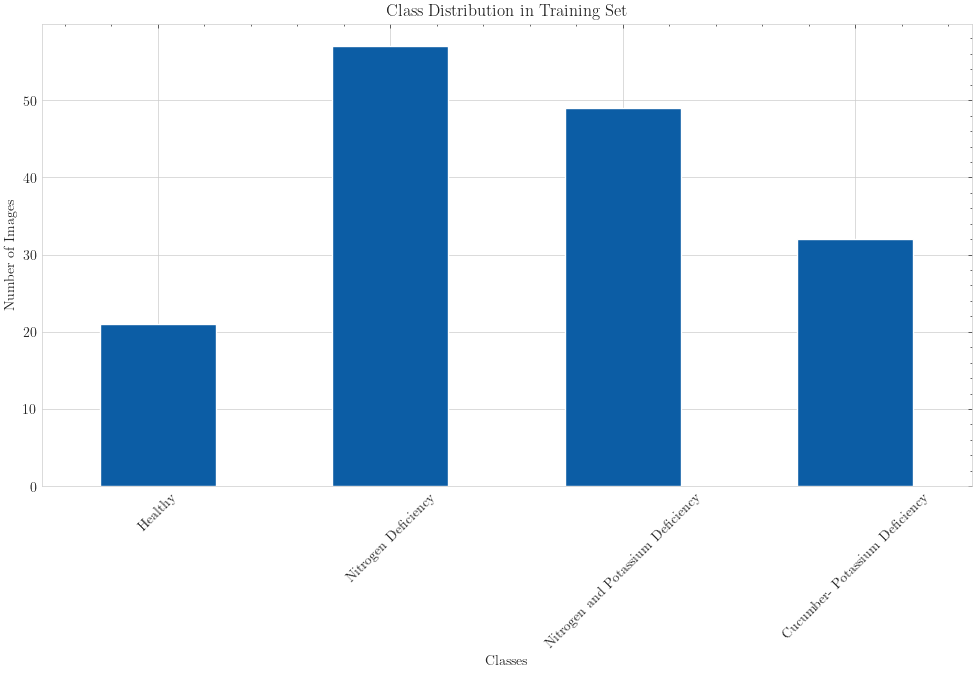

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

class_counts = train_generator.classes
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()}
class_counts = pd.Series(class_counts).value_counts().sort_index()
class_counts.index = class_counts.index.map(class_names)
class_counts.plot(kind="bar", title="Class Distribution in Training Set")
ax.set_xticklabels(class_counts.index.str.replace("Cucumber - ", ""), rotation=45)
plt.xlabel("Classes")
plt.ylabel("Number of Images")

In [10]:
train_generator.class_indices

{'Cucumber - Healthy': 0,
 'Cucumber - Nitrogen Deficiency': 1,
 'Cucumber - Nitrogen and Potassium Deficiency': 2,
 'Cucumber- Potassium Deficiency': 3}

In [11]:
def build_model():
    base_model = EfficientNetB0(
        input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet"
    )

    base_model.trainable = False

    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


model = build_model()

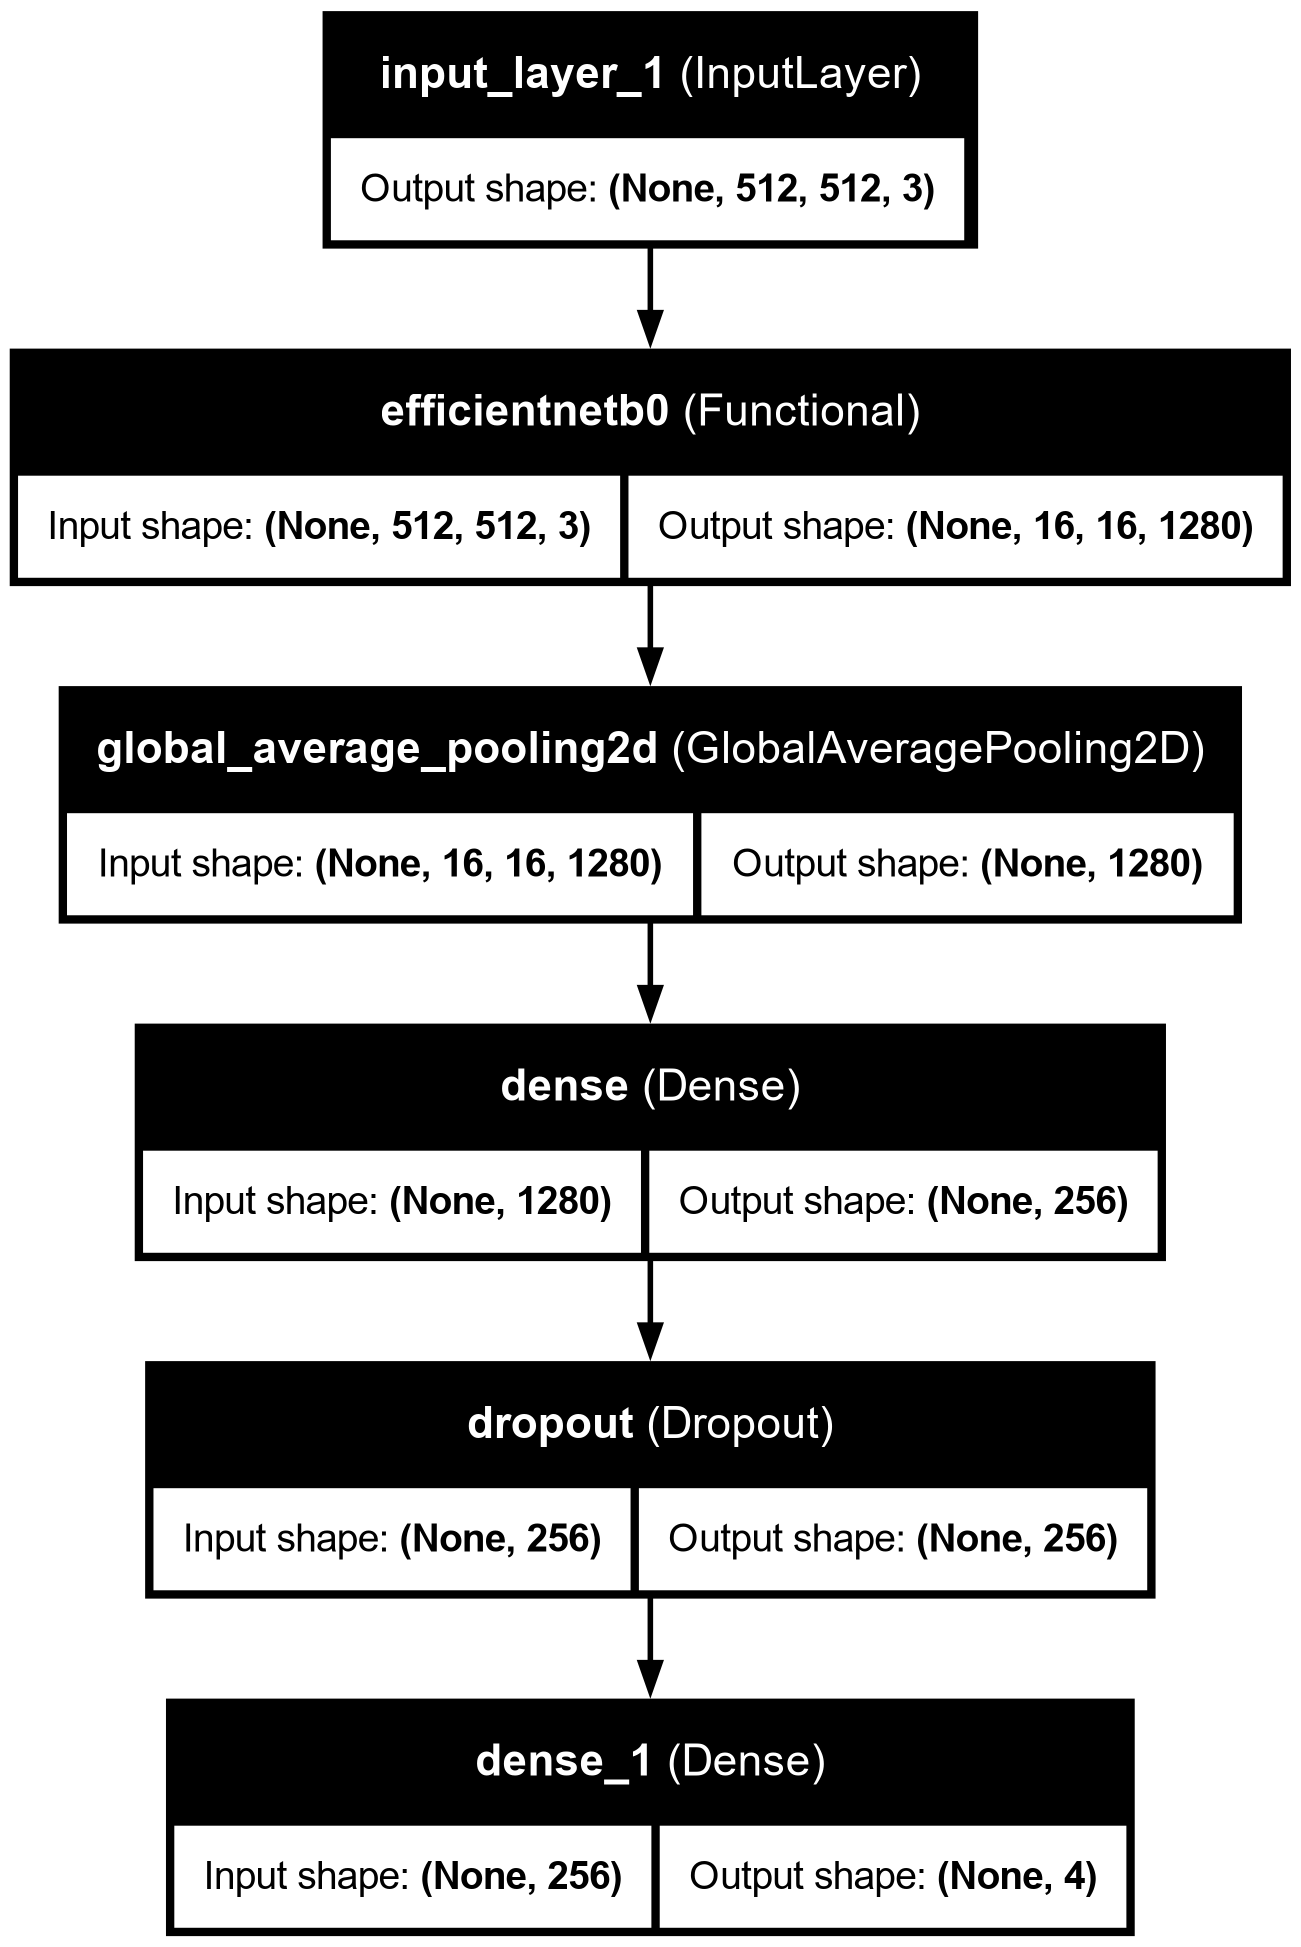

In [13]:
plot_model(
    model,
    to_file=OUTPUT_PATH / "model.png",
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        OUTPUT_PATH / "best_model.keras", save_best_only=True
    ),
]

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks,
)

## Melon


In [14]:
MELON_PATH = (
    Path(
        kagglehub.dataset_download("binnassor89/melon-macronutrient-deficiency-dataset")
    )
    / "Melon macronutrient deficeincy datasets"
)
print("Path to dataset files:", MELON_PATH)

Path to dataset files: /home/yubo/.cache/kagglehub/datasets/binnassor89/melon-macronutrient-deficiency-dataset/versions/1/Melon macronutrient deficeincy datasets


In [15]:
MELON_OUTPUT_PATH = OUTPUT_PATH / "melon"
MELON_OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
NUM_CLASSES = 4  # Ca/K/N/Healthy


def create_data_pipeline(subset):
    return image_dataset_from_directory(
        MELON_PATH,
        validation_split=0.1,
        subset=subset,
        label_mode="categorical",
        seed=42,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
    )


train_ds = create_data_pipeline("training")
val_ds = create_data_pipeline("validation")

Found 200 files belonging to 4 classes.
Using 180 files for training.


Found 200 files belonging to 4 classes.
Using 20 files for validation.


In [14]:
train_ds.class_names

['calcium', 'health', 'nitrogen', 'potasium']

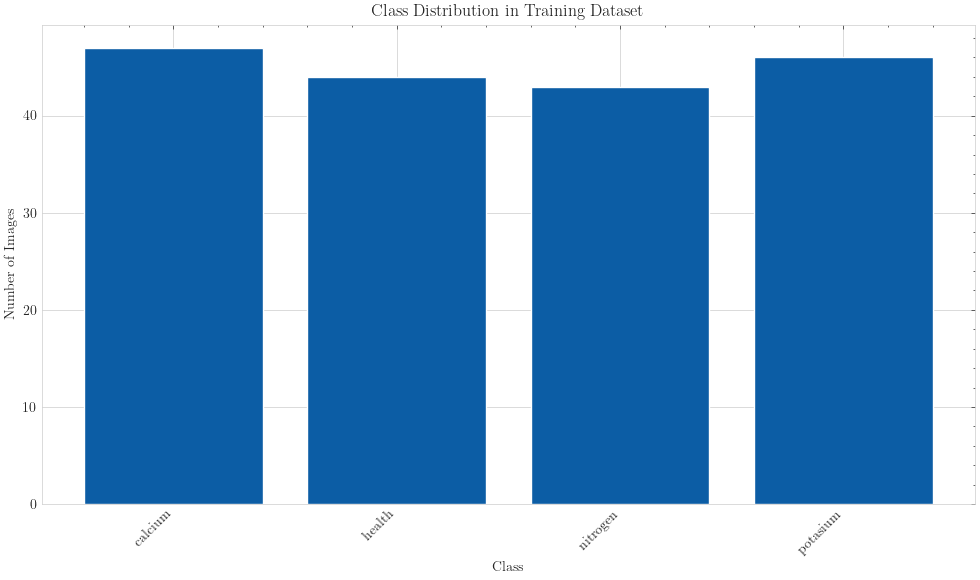

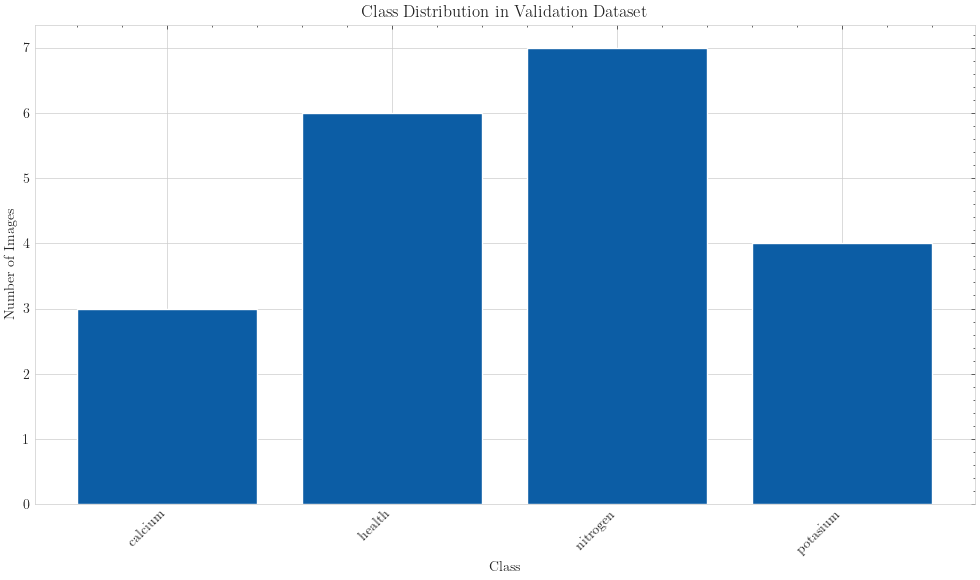

In [17]:
import numpy as np

import matplotlib.pyplot as plt


def get_labels(ds):
    labels = []
    for _, label_batch in ds:
        labels.extend(np.argmax(label_batch, axis=1))
    return np.array(labels)


train_labels = get_labels(train_ds)
val_labels = get_labels(val_ds)

class_names = train_ds.class_names


# Plotting function
def plot_class_distribution(labels, dataset_name, class_names):
    label_counts = np.bincount(labels)
    class_indices = np.arange(len(class_names))

    plt.figure(figsize=(10, 6))
    plt.bar(class_indices, label_counts, tick_label=class_names)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"Class Distribution in {dataset_name} Dataset")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


plot_class_distribution(train_labels, "Training", class_names)
plot_class_distribution(val_labels, "Validation", class_names)

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.1),
    ]
)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE,
).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

In [18]:
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras import layers, Model


def build_model():
    base_model = ConvNeXtTiny(
        include_top=False,
        weights="imagenet",
        input_shape=IMG_SIZE + (3,),
        pooling="avg",
    )

    base_model.trainable = False
    inputs = layers.Input(shape=IMG_SIZE + (3,))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = base_model(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(3e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


model = build_model()

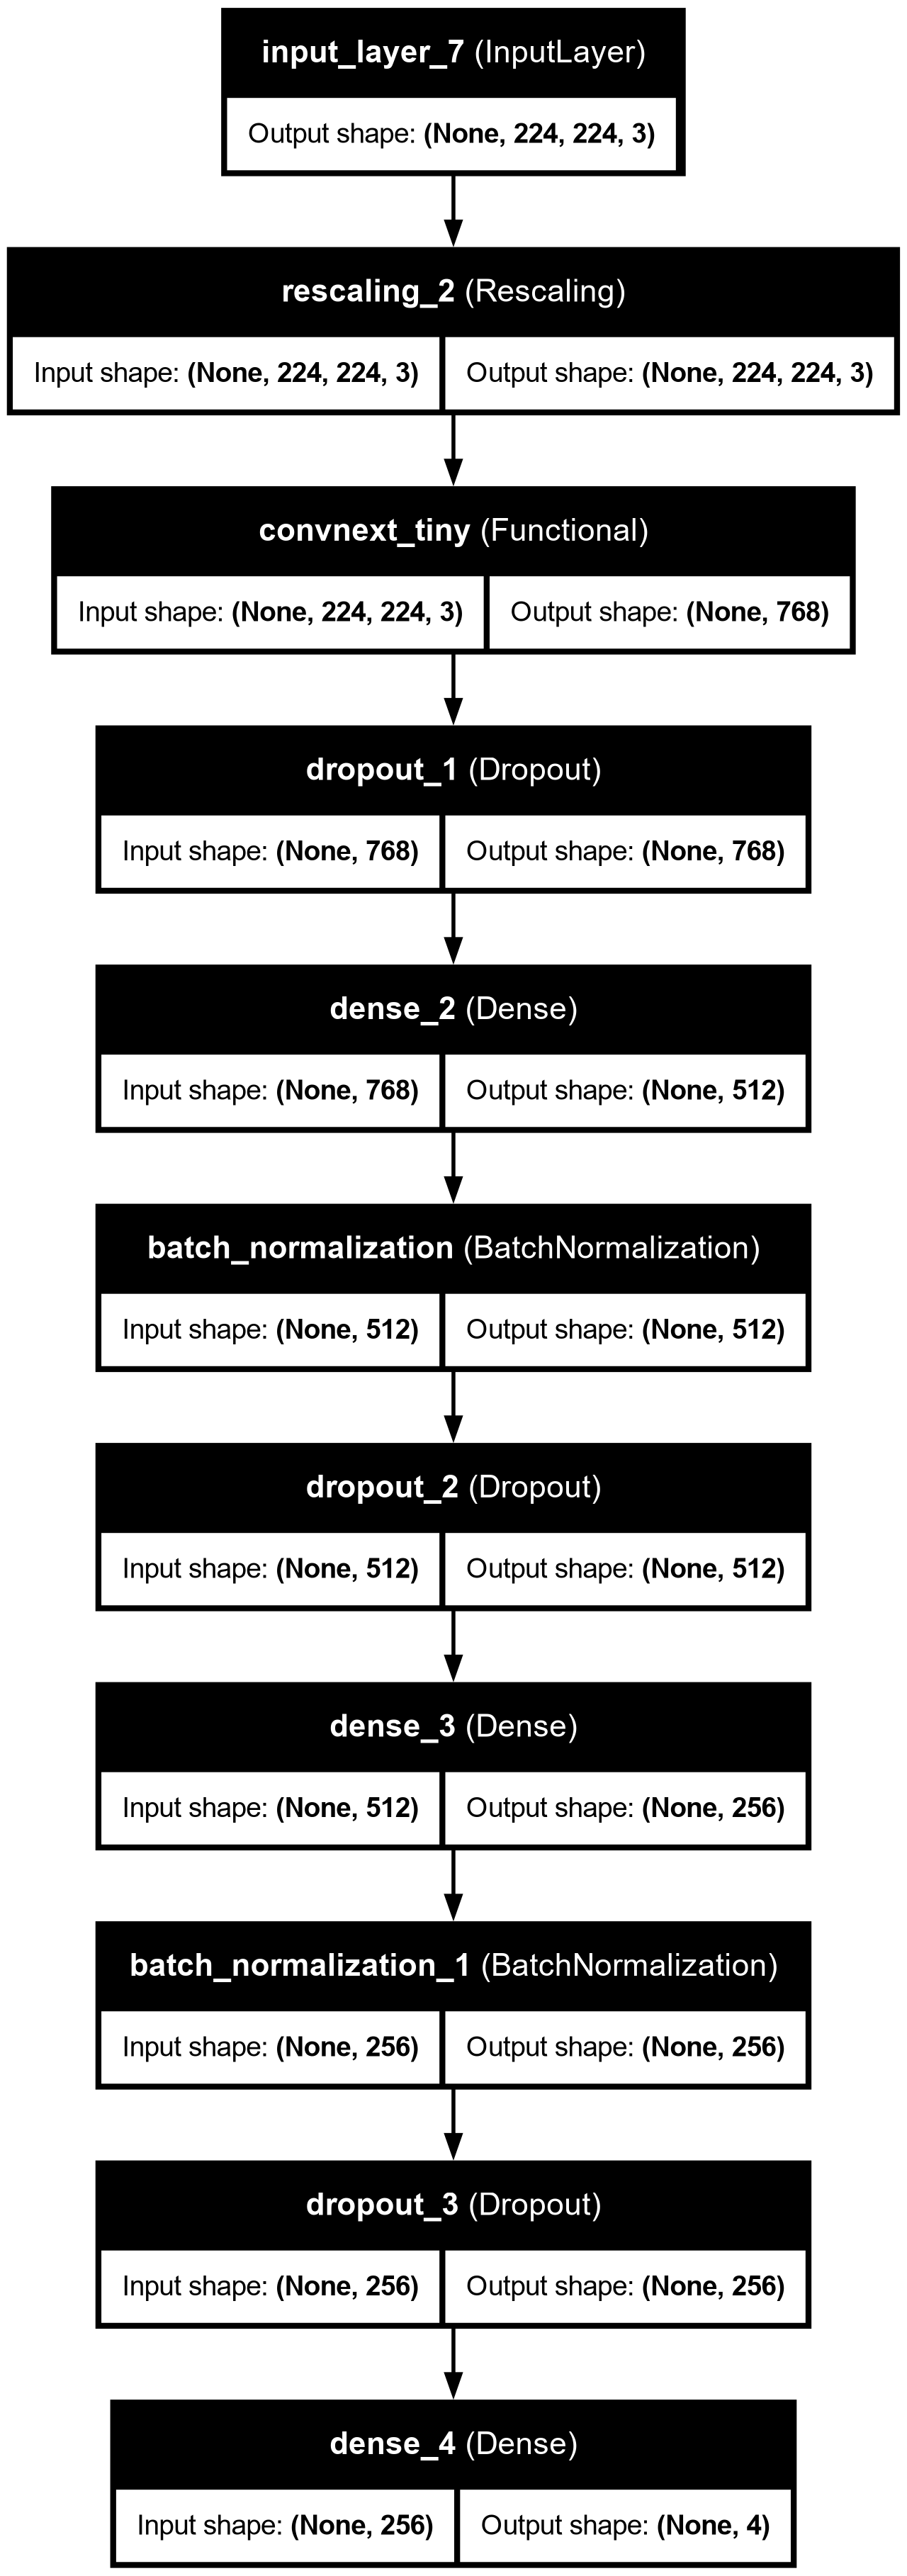

In [19]:
plot_model(
    model,
    to_file=OUTPUT_PATH / "melon_model.png",
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
initial_epochs = 10
history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
)

In [ ]:
model.save(MELON_OUTPUT_PATH / "melon_model_0.6.keras")

In [ ]:
base_model = model.layers[2]
base_model.trainable = True

for layer in base_model.layers:
    if layer.name.startswith("top"):
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", "F1Score"],
)

fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        monitor="val_accuracy",
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        OUTPUT_PATH / "fine_tuned_model.keras", save_best_only=True
    ),
]

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
)

In [ ]:
model.save(MELON_OUTPUT_PATH / "melon_model_0.6.keras")

## Rice


In [20]:
RICE_PATH = (
    Path(kagglehub.dataset_download("rusiri/leaf-color-dataset-for-paddy"))
    / "Oneplus 5T-20230113T195415Z-002"
    / "Soil Nitrogen Levels"
)
print("Path to dataset files:", RICE_PATH)
RICE_OUTPUT_PATH = OUTPUT_PATH / "rice"
RICE_OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

tree(RICE_PATH)

Path to dataset files: /home/yubo/.cache/kagglehub/datasets/rusiri/leaf-color-dataset-for-paddy/versions/2/Oneplus 5T-20230113T195415Z-002/Soil Nitrogen Levels
Soil Nitrogen Levels/
    Level 02/
    Level 03/
    Level 04/
    Level 05/


Total images: 788


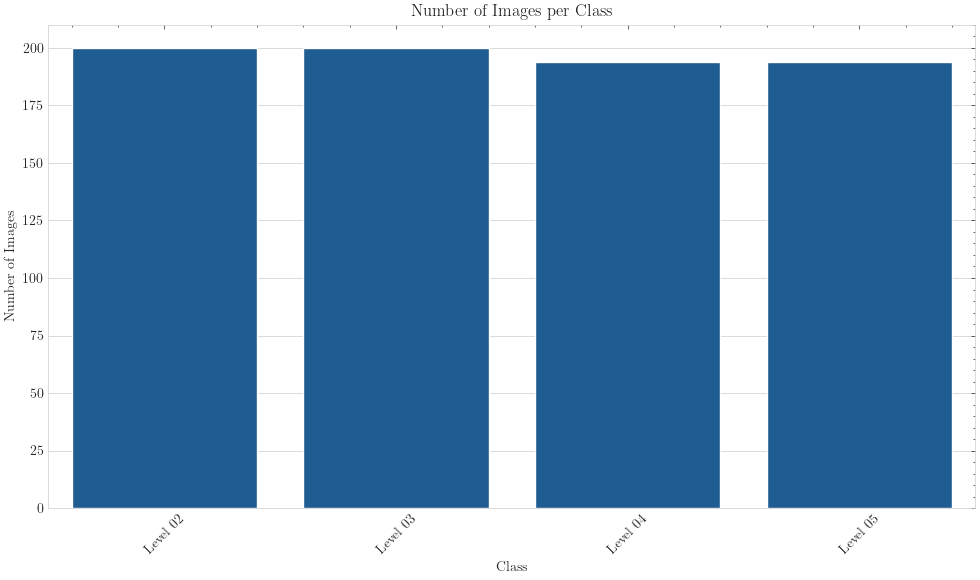

In [22]:
import os
import seaborn as sns
from collections import Counter
import pandas as pd

import matplotlib.pyplot as plt


# Function to count images in each subdirectory
def count_images(directory):
    counts = {}
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            image_count = len(
                [
                    name
                    for name in os.listdir(item_path)
                    if os.path.isfile(os.path.join(item_path, name))
                    and name.lower().endswith((".png", ".jpg", ".jpeg", ".gif", ".bmp"))
                ]
            )
            counts[item] = image_count
    total = sum(counts.values())
    print(f"Total images: {total}")
    return counts


# Count images in each class
image_counts = count_images(RICE_PATH)

# Convert to DataFrame for easy plotting
df = pd.DataFrame(list(image_counts.items()), columns=["Class", "Image Count"])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="Class", y="Image Count", data=df)
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (512, 512)
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 4  # You have 4 levels (02, 03, 04, 05)

# --- TFRecord Creation Functions ---


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def serialize_example(image, label):
    """Creates a TFRecord example from an image and label."""
    image_shape = image.shape
    image_string = tf.io.encode_jpeg(
        image, quality=95
    )  # Encode as JPEG, adjust quality
    feature = {
        "height": _int64_feature(image_shape[0]),
        "width": _int64_feature(image_shape[1]),
        "depth": _int64_feature(image_shape[2]),
        "label": _int64_feature(label),
        "image_raw": _bytes_feature(image_string),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def preprocess_image(image):
    """Resizes and center-crops an image."""
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG first
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE[0], IMG_SIZE[1])
    return image


def create_tfrecords(image_dir, output_file_prefix, split_name):
    """Creates TFRecords for a given directory."""
    class_names = sorted(os.listdir(image_dir))
    class_to_index = {name: i for i, name in enumerate(class_names)}

    output_file = f"{output_file_prefix}_{split_name}.tfrecord"
    with tf.io.TFRecordWriter(output_file) as writer:
        for class_name in class_names:
            class_dir = os.path.join(image_dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                try:
                    image = tf.io.read_file(image_path)
                    # Preprocess here (decode, resize, center crop)
                    image = preprocess_image(image)
                    label = class_to_index[class_name]
                    example = serialize_example(image, label)
                    writer.write(example)
                except Exception as e:
                    print(f"Skipping image {image_path} due to error: {e}")
    return output_file


# --- Create TFRecords (Run Once) ---
# Split into train and validation sets (80/20 split)
train_tfrecord_file = create_tfrecords(
    RICE_PATH, str(RICE_OUTPUT_PATH / "rice"), "train"
)
# create a symbolic link to the training set
val_tfrecord_file = str(RICE_OUTPUT_PATH / "rice_validation.tfrecord")
val_tfrecord_file = create_tfrecords(
    RICE_PATH, str(RICE_OUTPUT_PATH / "rice"), "validation"
)
# if not Path(val_tfrecord_file).exists():
#     os.symlink(
#         train_tfrecord_file, val_tfrecord_file
#     )  # link to it self since the dataset is small

# --- TFRecord Reading Functions ---


def parse_tfrecord_fn(example):
    """Parses a single TFRecord example."""
    feature_description = {
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "depth": tf.io.FixedLenFeature([], tf.int64),
        "label": tf.io.FixedLenFeature([], tf.int64),
        "image_raw": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example["image_raw"], channels=3)
    label = tf.one_hot(example["label"], depth=NUM_CLASSES)  # One-hot encode
    return image, label


def read_tfrecord_dataset(tfrecord_files, augment=False):
    """Reads and preprocesses a TFRecord dataset."""
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files, num_parallel_reads=AUTOTUNE)
    parsed_dataset = raw_dataset.map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)

    def _augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        return image, label

    # Normalize *after* parsing (and optionally augment)
    def _normalize(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    if augment:
        parsed_dataset = parsed_dataset.map(_augment, num_parallel_calls=AUTOTUNE)

    parsed_dataset = parsed_dataset.map(_normalize, num_parallel_calls=AUTOTUNE)

    return parsed_dataset


# --- Create Data Loaders ---

train_dataset = (
    read_tfrecord_dataset(train_tfrecord_file, augment=True)
    .shuffle(buffer_size=1000)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)

val_dataset = (
    read_tfrecord_dataset(val_tfrecord_file)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 320 extraneous bytes before marker 0xd9
Corrupt JPEG data: 154 extraneous bytes before marker 0xd9
Corrupt JPEG data: 183 extraneous bytes before marker 0xd9


In [ ]:
BATCH_SIZE = 16
IMG_SIZE = (512, 512)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    RICE_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    RICE_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

normalization_layer = layers.Rescaling(1.0 / 255)

augmentation_layers = tf.keras.Sequential(
    [
        layers.RandomRotation(0.2),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomContrast(0.2),
        layers.RandomZoom(0.2),
    ]
)

train_ds = train_ds.map(
    lambda x, y: (augmentation_layers(normalization_layer(x)), y),
    num_parallel_calls=AUTOTUNE,
).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(
    lambda x, y: (normalization_layer(x), y),
    num_parallel_calls=AUTOTUNE,
).prefetch(buffer_size=AUTOTUNE)

In [23]:
def build_model(num_classes):
    base_model = EfficientNetB7(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights="imagenet",
        pooling="avg",
    )

    x = layers.Dense(1024, activation="swish")(base_model.output)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation="swish")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    base_model.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


model = build_model(num_classes=4)

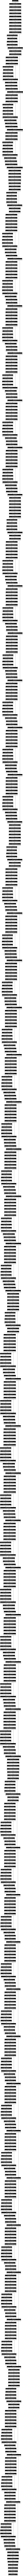

In [24]:
plot_model(
    model,
    to_file=OUTPUT_PATH / "rice_model.png",
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(RICE_OUTPUT_PATH / "best_model.h5", save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=2),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
)

base_model = model.layers[0]
base_model.trainable = True

for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
)

## Tomato


In [ ]:
TOMATO_PATH = (
    Path(kagglehub.dataset_download("mamtag/tomato-village"))
    / "Variant-a(Multiclass Classification)"
)
print("Path to dataset files:", TOMATO_PATH)
TOMATO_OUTPUT_PATH = OUTPUT_PATH / "tomato"
TOMATO_OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

tree(TOMATO_PATH)

Path to dataset files: /home/yubo/.cache/kagglehub/datasets/mamtag/tomato-village/versions/2/Variant-a(Multiclass Classification)
Variant-a(Multiclass Classification)/
    test/
        Early_blight/
        Healthy/
        Late_blight/
        Leaf Miner/
        Magnesium Deficiency/
        Nitrogen Deficiency/
        Pottassium Deficiency/
        Spotted Wilt Virus/
    train/
        Early_blight/
        Healthy/
        Late_blight/
        Leaf Miner/
        Magnesium Deficiency/
        Nitrogen Deficiency/
        Pottassium Deficiency/
        Spotted Wilt Virus/
    val/
        Early_blight/
        Healthy/
        Late_blight/
        Leaf Miner/
        Magnesium Deficiency/
        Nitrogen Deficiency/
        Pottassium Deficiency/
        Spotted Wilt Virus/


### AG


In [ ]:
import pandas as pd

train_dir = TOMATO_PATH / "train"

data = []

for label_dir in train_dir.iterdir():
    if label_dir.is_dir():
        for img_path in label_dir.glob("*"):
            if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                data.append({"image": img_path, "label": label_dir.name})

train_df = pd.DataFrame(data)

In [11]:
from autogluon.multimodal import MultiModalPredictor

predictor = MultiModalPredictor(
    label="label",
    path=TOMATO_OUTPUT_PATH / "automm_imgcls",
)
predictor.fit(train_data=train_df, time_limit=30)

=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 ZEN SMP PREEMPT_DYNAMIC Sat, 08 Feb 2025 18:54:38 +0000
CPU Count:          20
Pytorch Version:    2.5.1
CUDA Version:       12.6
Memory Avail:       12.94 GB / 38.86 GB (33.3%)
Disk Space Avail:   440.81 GB / 798.00 GB (55.2%)
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	8 unique label values:  ['Early_blight', 'Healthy', 'Late_blight', 'Leaf Miner', 'Magnesium Deficiency', 'Nitrogen Deficiency', 'Pottassium Deficiency', 'Spotted Wilt Virus']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal a

Epoch 0:   0%|          | 0/333 [00:00<?, ?it/s]                           

OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacity of 3.69 GiB of which 30.50 MiB is free. Including non-PyTorch memory, this process has 3.65 GiB memory in use. Of the allocated memory 3.42 GiB is allocated by PyTorch, and 127.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### TF2 (`deprecated`)


In [ ]:
def average_image_size(directory):
    total_width, total_height = 0, 0
    count = 0
    for img_path in directory.glob("**/*.jpg"):
        img = PIL.Image.open(img_path)
        count += 1
        total_width += img.width
        total_height += img.height
    return total_width / count, total_height / count


average_image_size(TOMATO_PATH)

In [86]:
df = pd.read_csv(TOMATO_PATH / "Multi-Label dataset - with augmented.csv")
df.columns

Index(['dataset', 'filename', 'path', 'Early blight', 'Healthy', 'Late blight',
       'Leaf Miner', 'Magnesium Deficiency', 'Nitrogen Deficiency',
       'Pottassium Deficiency', 'Spotted Wilt Virus', 'SUM'],
      dtype='object')

In [95]:
def build_image_path(row):
    return TOMATO_PATH / row["dataset"] / row["filename"]


df["full_path"] = df.apply(build_image_path, axis=1)

In [96]:
train_df = df[df["dataset"] == "train"]
val_df = df[df["dataset"] == "val"]
test_df = df[df["dataset"] == "test"]

In [98]:
LABEL_COLUMNS = [
    "Early blight",
    "Healthy",
    "Late blight",
    "Leaf Miner",
    "Magnesium Deficiency",
    "Nitrogen Deficiency",
    "Pottassium Deficiency",
    "Spotted Wilt Virus",
]


def create_dataset(df_subset):
    paths = df_subset["full_path"].values.astype(str)
    labels = df_subset[LABEL_COLUMNS].values.astype(np.float32)
    return tf.data.Dataset.from_tensor_slices((paths, labels))


def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return tf.keras.applications.efficientnet.preprocess_input(image), label


data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
    ]
)


def prepare_dataset(ds, shuffle=False, augment=False):
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


train_ds = prepare_dataset(create_dataset(train_df), shuffle=True, augment=True)
val_ds = prepare_dataset(create_dataset(val_df))
test_ds = prepare_dataset(create_dataset(test_df))


def build_model():
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=IMG_SIZE + (3,),
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = inputs
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(len(LABEL_COLUMNS), activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),  # 降低初始学习率
        loss=tf.keras.losses.BinaryCrossentropy(
            from_logits=False, label_smoothing=0.01  # 添加标签平滑
        ),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.AUC(name="auc", thresholds=[0.5]),
        ],
    )
    return model


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc", patience=5, mode="max", restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor="val_auc", mode="max"
)

model = build_model()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, model_checkpoint],
)

# 微调
model.load_weights("best_model.keras")
model.layers[1].trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")],
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, model_checkpoint],
)

print("\n测试集评估结果:")
model.evaluate(test_ds)

model.save("final_tomato_model", save_format="tf")

Epoch 1/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 56s 189ms/step - accuracy: 0.0015 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 2/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 35s 142ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 3/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 4/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 5/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 6/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - va

2025-02-13 22:56:03.553211: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at xla_ops.cc:577 : UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv.358 = (f32[16,96,257,257]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,96,259,259]{3,2,1,0} %pad.43, f32[96,1,3,3]{3,2,1,0} %bitcast.64926), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", metadata={op_type="DepthwiseConv2dNativeBackpropInput" op_name="gradient_tape/functional_29_1/efficientnetb0_1/block2a_dwconv_1/depthwise/DepthwiseConv2dNativeBackpropInput" source_file="/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1196}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTE

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_399314/2879846576.py", line 108, in <module>

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv.358 = (f32[16,96,257,257]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,96,259,259]{3,2,1,0} %pad.43, f32[96,1,3,3]{3,2,1,0} %bitcast.64926), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", metadata={op_type="DepthwiseConv2dNativeBackpropInput" op_name="gradient_tape/functional_29_1/efficientnetb0_1/block2a_dwconv_1/depthwise/DepthwiseConv2dNativeBackpropInput" source_file="/home/yubo/.anaconda3/envs/tf2/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1196}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 422582272 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_471289]